In [1]:
from altaipony.lcio import from_mast
import numpy as np
import matplotlib.pyplot as plt

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Find and download the LightCurveFile for your light curve:

In [2]:
flc = from_mast("29780677", mode="LC", c=2, mission="TESS")

Loading KWallet
Loading SecretService
Loading Windows
Loading chainer
Loading macOS
/usr/lib/python3.6/importlib/_bootstrap_external.py:487: ResourceWarning: unclosed <socket.socket fd=58, family=AddressFamily.AF_UNIX, type=SocketKind.SOCK_STREAM, proto=0, raddr=/run/user/1000/bus>
  code = marshal.loads(data)
/usr/lib/python3.6/importlib/_bootstrap_external.py:487: ResourceWarning: unclosed <socket.socket fd=59, family=AddressFamily.AF_UNIX, type=SocketKind.SOCK_STREAM, proto=0, raddr=/run/user/1000/bus>
  code = marshal.loads(data)
/usr/lib/python3.6/importlib/_bootstrap_external.py:487: ResourceWarning: unclosed <socket.socket fd=60, family=AddressFamily.AF_UNIX, type=SocketKind.SOCK_STREAM, proto=0, raddr=/run/user/1000/bus>
  code = marshal.loads(data)
/usr/lib/python3.6/importlib/_bootstrap_external.py:487: ResourceWarning: unclosed <socket.socket fd=61, family=AddressFamily.AF_UNIX, type=SocketKind.SOCK_STREAM, proto=0, raddr=/run/user/1000/bus>
  code = marshal.loads(data)
Foun

De-trend the light curve:

In [3]:
flcd = flc.detrend("savgol")

Now you can visually compare the results:

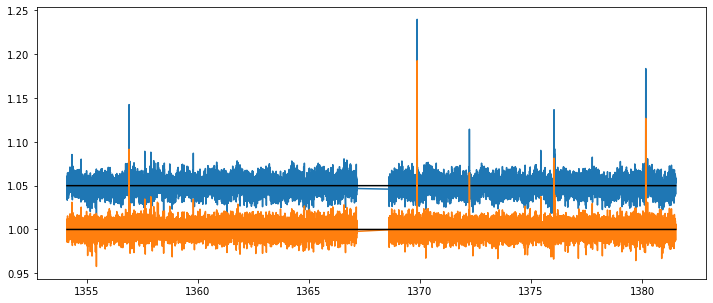

In [4]:
plt.figure(figsize=(12,5))

plt.plot(flcd.time, flcd.flux / np.nanmedian(flcd.flux)+0.05)
plt.plot(flcd.time, [1.05]*len(flcd.time), c="k")

plt.plot(flcd.time,flcd.detrended_flux / np.nanmedian(flcd.detrended_flux))
plt.plot(flcd.time, [1]*len(flcd.time), c="k")

#plt.xlim(1356.7,1357) # not a flare
#plt.xlim(1380,1380.5) # the largest flare
#plt.xlim(1375.8,1376.3) # the second largest flare

The periodicity in the raw light curve disappears in the de-trended one. Outliers and noise is still there.

Where are the flares?

In [5]:
flcd = flcd.find_flares()
flcd.flares.sort_values(by="ed_rec", ascending=False)

Found 0 candidate(s) in the (0,9227) gap.
Found 3 candidate(s) in the (9227,18317) gap.
/home/ekaterina/Documents/001_Science/AltaiPony/appaloosa_for_tess/lib/python3.6/site-packages/pandas-0.25.1-py3.6-linux-x86_64.egg/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,ampl_rec,cstart,cstop,ed_rec,ed_rec_err,istart,istop,tstart,tstop
2,0.127088,109949,109963,133.827370,3.810133,17387,17401,1380.163272,1380.182717
1,0.081642,106969,106987,121.109751,4.079850,14495,14513,1376.024417,1376.049417
0,0.192905,102541,102545,38.532367,1.566385,10142,10146,1369.874451,1369.880006


Not all visible outliers qualify for flare candidates, because we require a minimum a minimum of three outliers in a row for any candidate. 

What did the de-trending do to the flare candidates and their properties? 

Let's find out and try to find flares in the raw light curve.

In [6]:
flc.detrended_flux = flc.flux
flc.detrended_flux_err = flc.flux_err
flc = flc.find_flares()
flc.flares.sort_values(by="ed_rec", ascending=False)

Found 0 candidate(s) in the (0,9227) gap.
Found 4 candidate(s) in the (9227,18317) gap.


,ampl_rec,cstart,cstop,ed_rec,ed_rec_err,istart,istop,tstart,tstop
3,0.133967,109949,109965,155.903765,4.046517,17387,17403,1380.163272,1380.185494
2,0.086997,106969,106987,127.508457,4.073077,14495,14513,1376.024417,1376.049417
0,0.190166,102541,102545,38.409358,1.578282,10142,10146,1369.874451,1369.880006
1,0.040551,106547,106550,13.331994,1.710031,14085,14088,1375.438310,1375.442477


The large flares appear larger, and there is a small extra candidate. The former is because these flares occur when the stellar variability adds flux to the flare. If no de-trending occurs, variability is not accounted for. The extra flare will not be recognized as such in the de-trended light curve because it will not stick out enough (above 3 sigma level) from the quiescent flux.

But there is likely also an effect introduced by the de-trending algorithm itself. Here is where injection-recovery comes in:

In [7]:
flcd, fakeflc = flcd.sample_flare_recovery(inject_before_detrending=True, mode="savgol", 
                                          iterations=50, fakefreq=1, ampl=[1e-4, 0.5],
                                           dur=[.001/6., 0.1/6.]
                                          )

N/A%|                                                                         |
Detrending fake LC:

Found 12 candidate(s) in the (0,9213) gap.
Found 15 candidate(s) in the (9213,18280) gap.
  2%|#                                                                        |
Detrending fake LC:

Found 8 candidate(s) in the (0,9227) gap.
Found 13 candidate(s) in the (9227,18256) gap.
  4%|##                                                                       |
Detrending fake LC:

Found 10 candidate(s) in the (0,9226) gap.
Found 14 candidate(s) in the (9226,18316) gap.
  6%|####                                                                     |
Detrending fake LC:

Found 8 candidate(s) in the (0,9227) gap.
Found 14 candidate(s) in the (9227,18278) gap.
  8%|#####                                                                    |
Detrending fake LC:

Found 12 candidate(s) in the (0,9227) gap.
Found 13 candidate(s) in the (9227,18249) gap.
 10%|#######                                   

 86%|##############################################################           |
Detrending fake LC:

Found 10 candidate(s) in the (0,9178) gap.
Found 16 candidate(s) in the (9178,18236) gap.
 88%|################################################################         |
Detrending fake LC:

Found 11 candidate(s) in the (0,9226) gap.
Found 14 candidate(s) in the (9226,18316) gap.
 90%|#################################################################        |
Detrending fake LC:

Found 9 candidate(s) in the (0,9227) gap.
Found 12 candidate(s) in the (9227,18316) gap.
 92%|###################################################################      |
Detrending fake LC:

Found 9 candidate(s) in the (0,9226) gap.
Found 17 candidate(s) in the (9226,18316) gap.
 94%|####################################################################     |
Detrending fake LC:

Found 9 candidate(s) in the (0,9175) gap.
Found 14 candidate(s) in the (9175,18265) gap.
 96%|###########################################

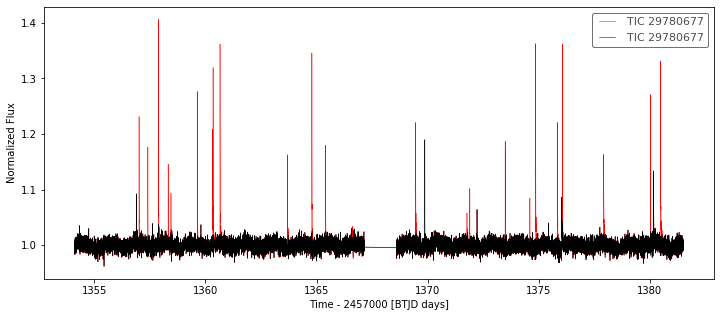

In [8]:
fig, ax = plt.subplots(figsize=(12,5))
fakeflc.plot(ax=ax,c="r");
flcd.plot(ax=ax,c="k")



In [9]:
print("The total number of injected flares is {}.".format(flcd.fake_flares.shape[0]))
print("Choose the bins below such that the number in each ampl-dur bin is >10 on average.")

The total number of injected flares is 1300.
Choose the bins below such that the number in each ampl-dur bin is >10 on average.


In [10]:
flcc = flcd.characterize_flares(ampl_bins=10, dur_bins=10) 

In [11]:
flcc.flares[["dur", "ampl_rec","ed_rec","tstart",
             "ed_ratio","recovery_probability",
             "ed_ratio_count","recovery_probability_std",
             "ed_corr",]].sort_values(by="ed_rec")

,dur,ampl_rec,ed_rec,tstart,ed_ratio,recovery_probability,ed_ratio_count,recovery_probability_std,ed_corr
0,0.005556,0.192905,38.532367,1369.874451,0.697470,0.773913,75.0,0.420127,55.245891
1,0.025000,0.081642,121.109751,1376.024417,0.894637,0.707317,3.0,0.456855,135.373099
2,0.019444,0.127088,133.827370,1380.163272,0.579786,0.968750,51.0,0.175368,230.822094


Depending on the statistics of the injected flares, the middle sized flare may not have been captured by the injection recovery grid (or only with a small number in `ed_ratio_count`). 

We can solve this by increasing either the number of iterations in `sample_flare_recovery` or changing the range of amplitudes and durations injected, or both. But the latter is difficult to know a priori because we do not know how recovered amplitudes and durations map to injected ones. You will have to tinker with the parameters at the moment, like `dur` and `ampl` in sample flare_recovery, or `ampl_bins` and `dur_bins` in `characterize_flares`. 

A cross-check for the quality of the values for ED ratio (`ed_ratio`) and recovery probability (`recovery_probability`) are the respective counts, that is the number of synthetic flares that exhibit the true and recovered characteristics. So the ED ratio for the small flare may suffer from only 9 flares in the respective bin. Usually, ~100 events in a bin is a good heuristic. But you should also check the `_std` values for the intristic scatter in `ed_corr` and `recovery_probability`. The latter will show that the uncertainty on recovery probability for the smallest flare is ~.48, which you may choose as criterion for excluding this candidate from the results. 

Caution: low number in `ed_ratio_count` may also mean that the recovery probability at these energies is just low, especially when `ed_rec` is small.





Questions? Something does not work? Email me @ eilin@aip.de 